# Predicting Netflix stock prices using Machine Learning.

prediction stock price in there parts.

1. Long Term Prediction
2. Middel Term Prediction
3. Short Term Perdiction

In [24]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy as sp
import os
from scipy import signal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error


plt.style.use("ggplot")
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 
          'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 
          'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [5]:
from tqdm import tqdm_notebook
import imageio
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf, acf

In [6]:
# load the data

data = pd.read_csv("netflix.csv")
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429


Text(0, 0.5, 'Date')

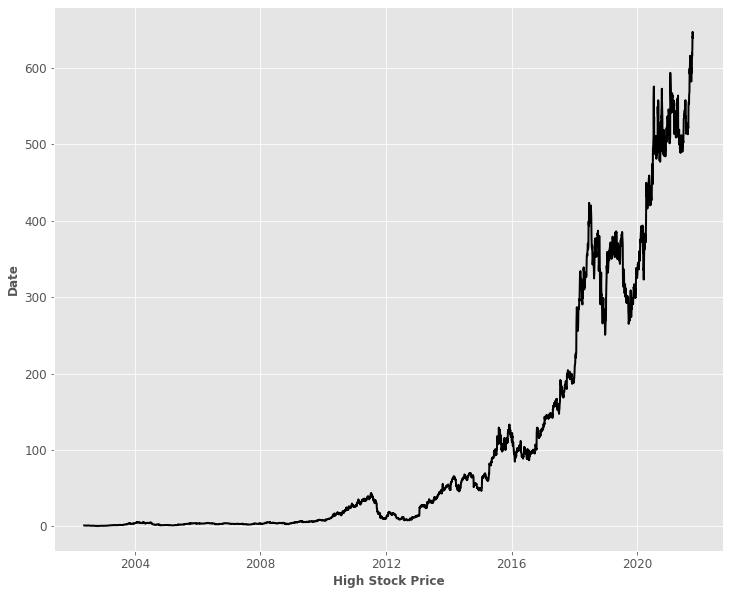

In [9]:
# visualize the stock high

y = np.array(data.High)
time = np.array(data.Date)
time = pd.to_datetime(time)
plt.plot(time,y,color = "k")
plt.xlabel("High Stock Price")
plt.ylabel("Date")

# 1.Long Term Prediction

all time prediction based on all the data we have.

Training set to test different kinds of models, with different kinds of degrees of the polynomial. Then used the validation set to 
pick the one model with the lowest Mean Squared Error, and applied the optimal degree to the test set.

In [20]:
# trying different models
train_split = int(len(y)*0.9)
val_split = int(len(y)*0.05)
y_train = y[0:train_split]
X_train = np.arange(0, len(y_train), 1).reshape(-1,1)
X_tot = np.arange(0, len(y),1).reshape(-1,1)
X_val= np.arange(train_split, train_split+val_split,1).reshape(-1,1)
X_test = np.arange(train_split+val_split, len(y),1).reshape(-1,1)
y_val = y[train_split: train_split+val_split]


In [25]:
mse_list = []
degrees = np.arange(3,12,1)
for d in degrees:
    poly = PolynomialFeatures(d)
    new_X_train = poly.fit_transform(X_train)
    lr = LinearRegression()
    lr.fit(new_X_train, y_train)
    new_X_val = poly.fit_transform(X_val)
    y_pred = lr.predict(new_X_val)
    mse_list.append(mean_squared_error(y_pred, y_val))
    

In [26]:
mse_data = pd.DataFrame({"MSE" : mse_list, "Degrees" : degrees})
mse_data.sort_values("MSE")

,MSE,Degrees
0,2985.976552,3
2,3473.201420,5
3,4000.106752,6
1,4434.413559,4
4,12439.154496,7
5,35626.214884,8
6,80279.710944,9
7,152892.283797,10
8,259216.002452,11


the model with the lowest MSE is the one with degree = 3

In [72]:
train_split = int(len(y)*0.9)
val_split = int(len(y)*0.05)
y_train = y[0:train_split]
X_train = np.arange(0,len(y_train),1).reshape(-1,1)
X_tot =  np.arange(0,len(y),1).reshape(-1,1)
opt_degree = 3
poly = PolynomialFeatures(opt_degree)
new_X_tot = poly.fit_transform(X_tot)
new_X_train = poly.fit_transform(X_train)
new_X_val = poly.fit_transform(X_val)
new_X_test = poly.fit_transform(X_test)


lr = LinearRegression()
lr.fit(new_X_train,y_train)


y_pred_train = lr.predict(new_X_train)
y_pred_val = lr.predict(new_X_val)
y_pred_test = lr.predict(new_X_test)

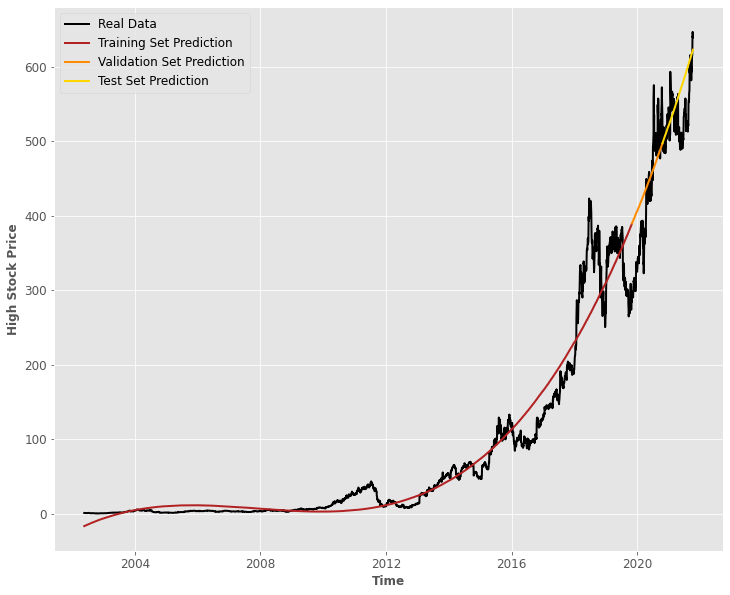

In [73]:
plt.plot(time,y,color='k',label='Real Data')
plt.xlabel('Time')
plt.ylabel('High Stock Price')
plt.plot(time[0:train_split],y_pred_train,color='firebrick',label='Training Set Prediction')
plt.plot(time[train_split:train_split+val_split],y_pred_val,color='darkorange',label='Validation Set Prediction')
plt.plot(time[train_split+val_split::],y_pred_test,color='gold',label='Test Set Prediction')
plt.legend()

We can see that we are capturing the trend pretty well. Of course, it is just a 3-degree polynomial so it doesn’t follow all the ups and downs of the real stock price. The good thing is that it is not supposed to predict the ups and downs as it is considered to be a long term prediction.

As this prediction has been made, we can isolate it and de-trend the original signal to study these up and down by themselves:

In [74]:
y_pred = lr.predict(new_X_tot)

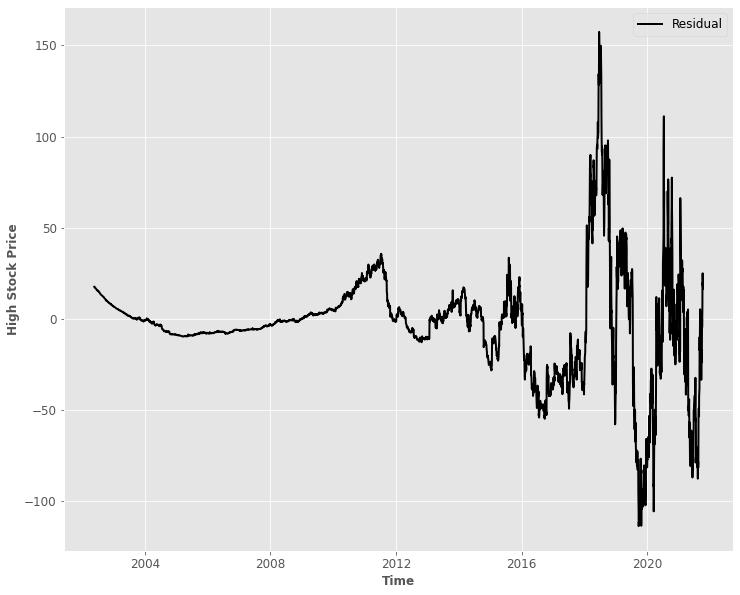

In [75]:
y_detrend = y-y_pred
plt.plot(time,y_detrend,label='Residual',color='k')
plt.xlabel('Time')
plt.ylabel('High Stock Price')
plt.legend()

In [76]:
detrend_data = pd.DataFrame([time,y_detrend]).T
detrend_data = detrend_data.rename(columns={0:'Date',1:'y'})

In [77]:
detrend_data

,Date,y
0,2002-05-23,17.643197
1,2002-05-24,17.549244
2,2002-05-28,17.480418
3,2002-05-29,17.336721
4,2002-05-30,17.204579
...,...,...
4876,2021-10-05,19.680396
4877,2021-10-06,18.608498
4878,2021-10-07,25.026328
4879,2021-10-08,21.433764


This is the new signal, which is ready to be considered for the Middle Term Prediction.

# 2.Middel Term Prediction

To do this kind of prediction, the first thing to do is average the signal and consider its montly mean.

In [84]:
month_data=pd.DataFrame(detrend_data.groupby(pd.PeriodIndex(detrend_data['Date'], freq="M"))['y'].mean())
month_data=month_data.reset_index()
month_data['Date']=pd.to_datetime(month_data.Date,errors='ignore')
to_plot_month = month_data.loc[np.linspace(month_data.index.min(),month_data.index.max(),5).astype(int)]

Text(0, 0.5, 'High Stock Price')

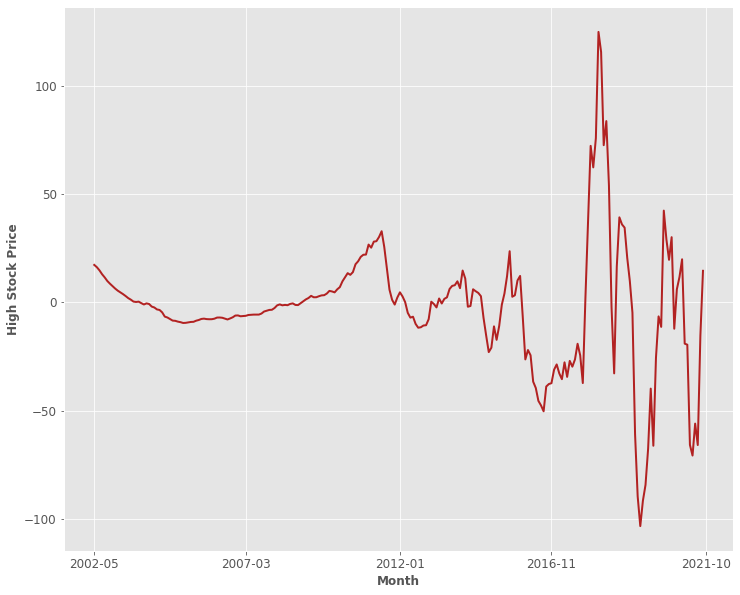

In [85]:
plt.plot(month_data['y'],color='firebrick')
plt.xticks(np.linspace(0,234,5).astype(int),to_plot_month.Date)
plt.xlabel('Month')
plt.ylabel('High Stock Price')


Now we want to consider what happened in a certain number of months (let’s say 44) and predict what is going to happen in the next three months.

The tool we are going to use in our case is an ARIMA model. Again, we are trying to understand the coefficient of a linear model and its uncertainty which is modeled to be noise .

Let’s consider what happens from 2017:

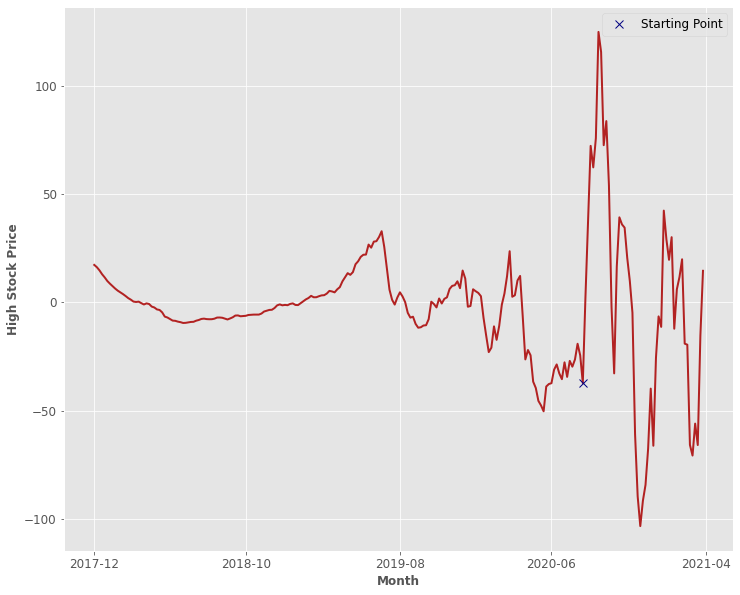

In [89]:
stop_time = 187
plt.plot(month_data['y'],color='firebrick')
plt.plot(stop_time,month_data['y'][stop_time],'x',color='navy',label='Starting Point')
plt.xticks(np.linspace(0,len(month_data),5).astype(int),to_plot_month)
plt.xlabel('Month')
plt.ylabel('High Stock Price')
plt.legend()

Given what we have in blue we want to predict what we have see in red.

In [140]:
new_data = month_data[stop_time::]
new_data = new_data.reset_index().drop('index',axis=1)
new_year_index = 43
new_data_train = new_data[0:new_year_index+1]
new_data_test = new_data[new_year_index:new_year_index+3]
to_plot_index = np.linspace(new_data.index.min(),new_data_test.index.max(),5).astype(int)
to_plot_month = new_data.loc[to_plot_index].Date
series = new_data_train.y

Text(0, 0.5, 'High Stock Price')

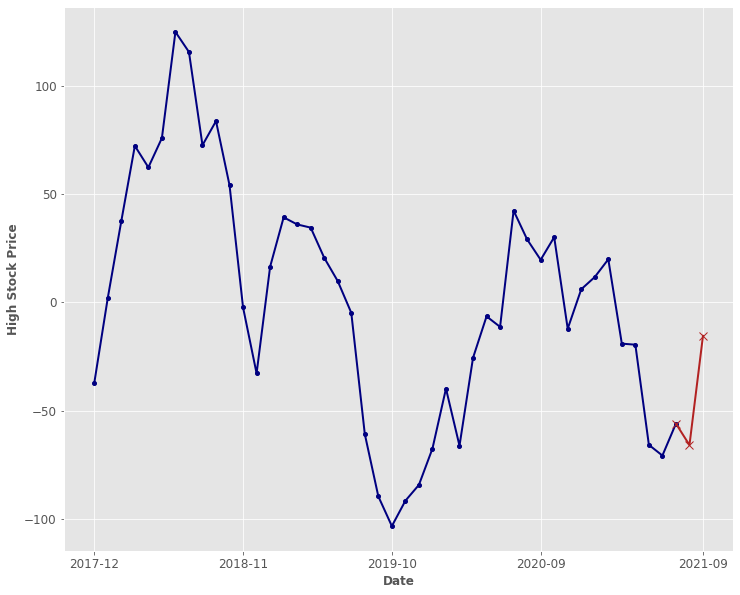

In [141]:
plt.plot(new_data_train.index,new_data_train.y,color='navy',marker='.',label='Training Set')
plt.plot(new_data_test.index,new_data_test.y,color='firebrick',marker='x',label='Test Set')
plt.xticks(to_plot_index,to_plot_month)
plt.xlabel('Date')
plt.ylabel('High Stock Price')

This is the function we are going to use:


In [127]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p,d,q) tuples
        exog - the exogenous variable
    """
    
    result = []
    
    for order in tqdm_notebook(order_list):
        model = SARIMAX(exog, order = order).fit(disp = -1)
        
        aic = model.aic
        result.append([order, model.aic])
        
    result_df = pd.DataFrame(result)
    result_df.columns = ["(p,d,q)", "AIC"]
    
    # sort in ascending order, lower AIC  is better
    
    result_df = result_df.sort_values(by = 'AIC').reset_index(drop=True)
    
    return result_df
        

In [128]:
import warnings
warnings.filterwarnings("ignore")

In [129]:
ps = range(0,10,1)
d = 0
qs = range(0,10,1)

# create a list with all possible combination of parameter
parameters = product(ps, qs)
parameter_list = list(parameters)

order_list = []

for each in parameter_list:
    each = list(each)
    each.insert(1,d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series)

  0%|          | 0/100 [00:00<?, ?it/s]

This is the value of AIC: we are going to pick the best model out of it.

In [130]:
result_d_0.head()

,"(p,d,q)",AIC
0,"(2, 0, 1)",420.671115
1,"(2, 0, 0)",421.263843
2,"(1, 0, 1)",421.566007
3,"(1, 0, 0)",421.718752
4,"(4, 0, 0)",421.826936


This is a statistic of our best model

In [131]:
best_models = result_d_0.sort_values(by = 'AIC', ascending = True).reset_index(drop=True).head()
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_0 = SARIMAX(series, order = best_model_params_0).fit()
print(best_model_0.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -206.336
Date:                Sun, 06 Nov 2022   AIC                            420.671
Time:                        01:09:53   BIC                            427.808
Sample:                             0   HQIC                           423.318
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8173      0.098     18.452      0.000       1.624       2.010
ar.L2         -0.8729      0.085    -10.323      0.000      -1.039      -0.707
ma.L1         -0.8664      0.173     -5.019      0.0

define the result variable

In [132]:
test_size = len(new_data_test)-1
train_size = int(len(series))
fore_l = test_size
forecast = best_model_0.get_prediction(start=train_size-1,end = train_size + fore_l -1)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha =0.05)

Text(0, 0.5, 'High Stock Price')

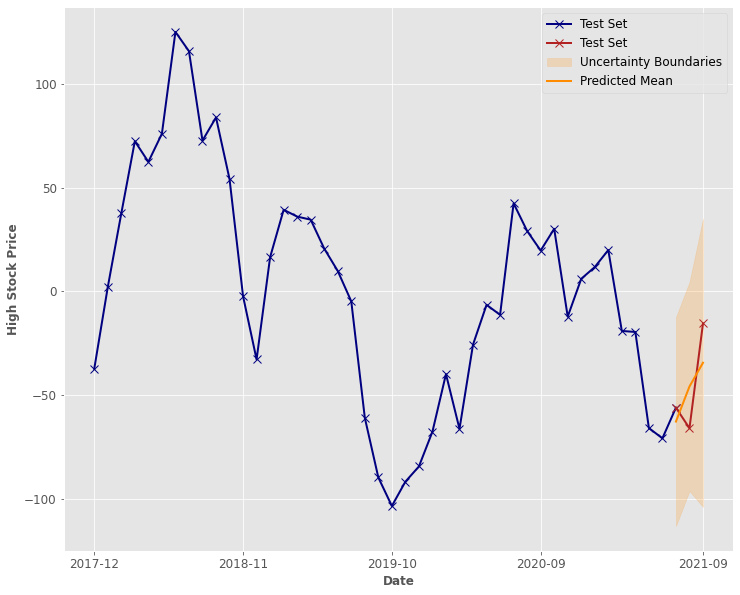

In [133]:
plt.plot(new_data_train.index,new_data_train.y[0::],color='navy',marker='x',label='Test Set')
plt.plot(new_data_test.index,new_data_test.y[0::],color='firebrick',marker='x',label='Test Set')
plt.fill_between(new_data_test.index,ci['lower y'],ci['upper y'],alpha=0.2,color='darkorange',label='Uncertainty Boundaries')
plt.plot(new_data_test.index,forec,label='Predicted Mean',color='darkorange')
plt.legend()
plt.xticks(to_plot_index,to_plot_month)
plt.xlabel('Date')
plt.ylabel('High Stock Price')

A few considerations:

. The boundaries are pretty large, but it is because we want to have the 95% of confidence, we can decrease the boundaries if we accept the fact that we may be wrong with more than 95% of uncertainty

. The model is actually predicting that we will have an uprising trend for the next three months. Yay. :D

# 3.Short Term Prediction

we want to predict the next three days given the privious 41 days.


This is the definition of the new dataset and its plot

In [147]:
min_month_index = detrend_data[detrend_data["Date"] =="2017-12-01"].index[0]
min_index = min_month_index + np.argmin(detrend_data[min_month_index: min_month_index + 30].y)
                                        
                                                

In [148]:
new_data = detrend_data[min_index::]
new_data = new_data.reset_index().drop("index", axis = 1)

In [151]:
new_data = new_data.loc[new_data.index.max() - 200 +35: new_data.index.max() - 200+45+35].reset_index().drop("index", axis = 1)
train_size = 40
new_data_train = new_data[0:train_size+ 1]
new_data_test = new_data[train_size : 43]
to_plot_index = np.linspace(new_data.index.min(), new_data.index.max(),5).astype(int)
to_plot_day = new_data.loc[to_plot_index].Date
series = new_data_train.y


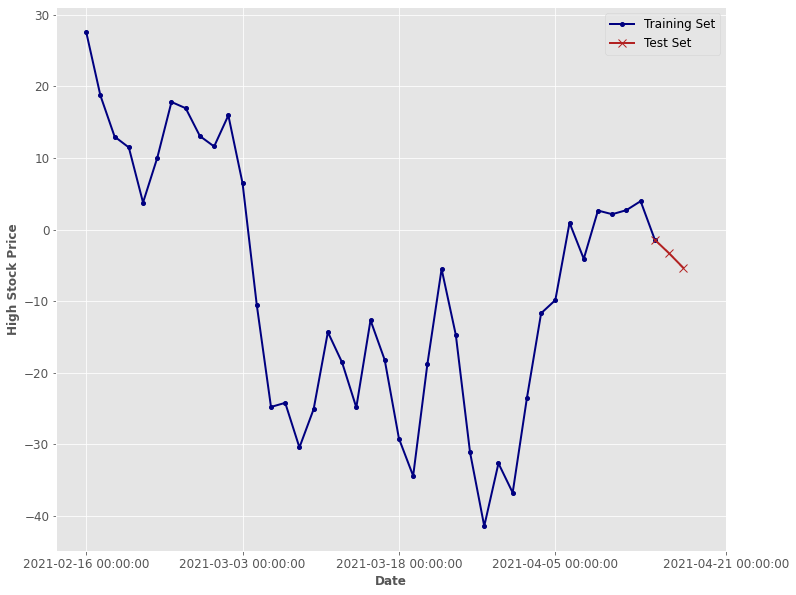

In [159]:
plt.plot(new_data_train.index, new_data_train.y, color = "navy", marker = ".",label = "Training Set")
plt.plot(new_data_test.index, new_data_test.y, color = "firebrick", marker = "x" , label = "Test Set")
plt.xticks(to_plot_index, to_plot_day)
plt.xlabel("Date")
plt.ylabel("High Stock Price")
plt.legend()


optimization process

In [160]:
series = series.astype('float')


In [175]:
ps = range(0,10,1)
d = 0
qs = range(0,10,1)

# create a list with all possible combination of parameter
parameter = product(ps, qs)
parameter_list = list(parameter)

order_list =[]

for each in parameter_list:
    each = list(each)
    each.insert(1,d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series)

  0%|          | 0/100 [00:00<?, ?it/s]

In [176]:
result_d_0.head()

,"(p,d,q)",AIC
0,"(1, 0, 1)",294.642347
1,"(2, 0, 0)",295.649036
2,"(2, 0, 1)",296.337997
3,"(3, 0, 0)",296.429659
4,"(1, 0, 2)",296.499609


In [178]:
best_models = result_d_0.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_0 = SARIMAX(series, order=best_model_params_0).fit()
print(best_model_0.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -144.321
Date:                Sun, 06 Nov 2022   AIC                            294.642
Time:                        02:04:13   BIC                            299.783
Sample:                             0   HQIC                           296.514
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8432      0.089      9.493      0.000       0.669       1.017
ma.L1          0.3768      0.158      2.392      0.017       0.068       0.686
sigma2        63.7345     23.080      2.761      0.0

In [179]:
test_size = len(new_data_test)
fore_l= test_size+3
forecast = best_model_0.get_prediction(start=train_size+1, end=train_size+fore_l-3)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.25)

Text(0, 0.5, 'High Stock Price')

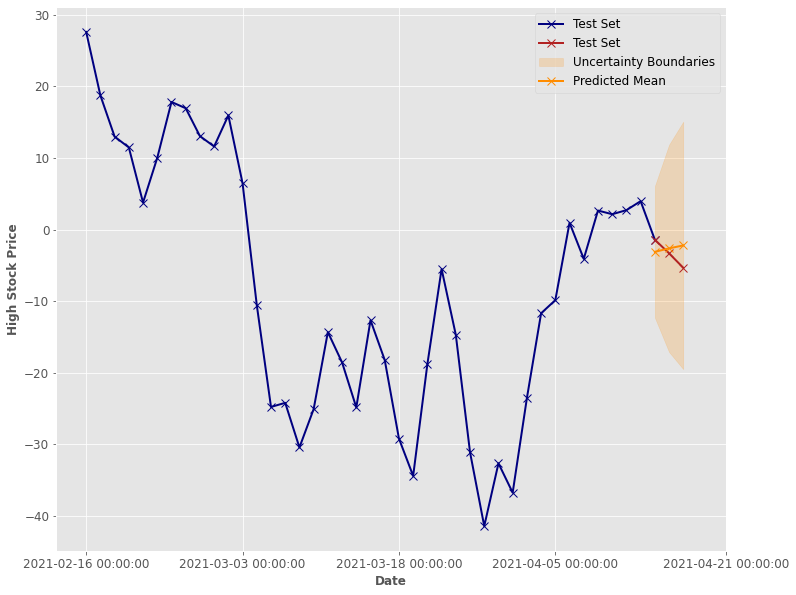

In [180]:
plt.plot(new_data_train.index,new_data_train.y[0::],color='navy',marker='x',label='Test Set')
plt.plot(new_data_test.index,new_data_test.y[0::],color='firebrick',marker='x',label='Test Set')
plt.fill_between(new_data_test.index,ci['lower y'],ci['upper y'],alpha=0.2,color='darkorange',label='Uncertainty Boundaries')
plt.plot(new_data_test.index.tolist(),forec,label='Predicted Mean',color='darkorange',marker='x')
plt.legend()
plt.xticks(to_plot_index,to_plot_day)
plt.xlabel('Date')
plt.ylabel('High Stock Price')